# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# path = r'/content/drive/My Drive/ECE1512/ProjectB/'
# import os
# os.chdir(path)  # Change the directory to torchRay-master folder
# import sys
# sys.path.insert(0, path)

In [2]:
!pip install keras-flops

In [3]:
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt
from typing import Union
from keras_flops import get_flops
import numpy as np

tf.enable_v2_behavior()

BATCH_SIZE = 32
INIT_EPOCHS = 10
FINETUNE_EPOCHS = 25
IMG_SIZE = (224, 224, 3)

In [4]:
# import csv
# import shutil
# source_folder = 'images'
# target_folder = 'MHIST'
# with open('annotations.csv', 'r') as file:
#   reader = csv.reader(file)
#   next(reader, None)
#   for row in reader:
#     from_path = f'{source_folder}/{row[0]}'
#     to_path = f'{target_folder}/{row[3]}/{row[1]}/{row[0]}'
#     shutil.copy(from_path, to_path)

# Data loading

In [5]:
# Load train and test splits.
mhist_train = tf.keras.utils.image_dataset_from_directory('MHIST/train', 
                                                          shuffle=True, 
                                                          label_mode= 'categorical',
                                                          batch_size=BATCH_SIZE, 
                                                          image_size=IMG_SIZE[:2])

mhist_test = tf.keras.utils.image_dataset_from_directory('MHIST/test', 
                                                         shuffle=False, 
                                                         label_mode= 'categorical',
                                                         batch_size=BATCH_SIZE, 
                                                         image_size=IMG_SIZE[:2])

Found 2175 files belonging to 2 classes.
Found 977 files belonging to 2 classes.


In [57]:
# Build teacher.
teacher_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SIZE, include_top=False, weights='imagenet')
teacher_model.trainable = False

teacher_model = tf.keras.Sequential([
    teacher_model.input,
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    teacher_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2),
])

# Build student.
student_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE, include_top=False, weights='imagenet')
student_model.trainable = False

student_model = tf.keras.Sequential([
    student_model.input,
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    student_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2),
])

# Build student without distill.
student_model_no_distillation = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE, include_top=False, weights='imagenet')
student_model_no_distillation.trainable = False

student_model_no_distillation = tf.keras.Sequential([
    student_model_no_distillation.input,
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    student_model_no_distillation,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2),
])

# Teacher loss function

In [7]:
def compute_teacher_loss(images, labels):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = teacher_model(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, class_logits, from_logits=True)
  )
  return cross_entropy_loss_value

# Student loss function

In [58]:
# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 64. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student_model(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3
  teacher_class_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, 
                                              student_class_logits, 
                                              DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, 
                                         from_logits=True))
  
  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_class_logits = student_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, from_logits=True))
  
  return cross_entropy_loss

# Train and evaluation

In [9]:
def train_and_evaluate(model, compute_loss_fn, if_eval=True, num_epochs=10, lr=1e-4):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(lr)

  for epoch in range(1, num_epochs + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mhist_train:
      with tf.GradientTape() as tape:
        # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    if if_eval is True:
      num_correct = 0
      num_total = 977
      m = tf.keras.metrics.AUC(from_logits=True)
      for images, labels in mhist_test:
        # your code start from here for step 4
        class_logits = model(images, training=False)
        m.update_state(labels, class_logits)
      print("AUC: " + '{:.2f}'.format(m.result().numpy()))


# Training models

In [52]:
# your code start from here for step 5 
# train_and_evaluate(teacher_model, compute_teacher_loss, num_epochs=10, lr=1e-4)

# teacher_model.trainable = True
# train_and_evaluate(teacher_model, compute_teacher_loss, num_epochs=25, lr=1e-5)

# teacher_model.save('./task2_teacher.h5')
teacher_model = tf.keras.models.load_model('./task2_teacher.h5')

In [59]:
# Train Student Model
train_and_evaluate(student_model, compute_student_loss, num_epochs=10, lr=1e-3)

student_model.trainable = True
train_and_evaluate(student_model, compute_student_loss, num_epochs=25, lr=1e-4)

Epoch 1: AUC: 0.67
Epoch 2: AUC: 0.66
Epoch 3: AUC: 0.67
Epoch 4: AUC: 0.69
Epoch 5: AUC: 0.63
Epoch 6: AUC: 0.64
Epoch 7: AUC: 0.69
Epoch 8: AUC: 0.69
Epoch 9: AUC: 0.71
Epoch 10: AUC: 0.69
Epoch 1: AUC: 0.75
Epoch 2: AUC: 0.74
Epoch 3: AUC: 0.76
Epoch 4: AUC: 0.75
Epoch 5: AUC: 0.75
Epoch 6: AUC: 0.75
Epoch 7: AUC: 0.75
Epoch 8: AUC: 0.76
Epoch 9: AUC: 0.76
Epoch 10: AUC: 0.77
Epoch 11: AUC: 0.76
Epoch 12: AUC: 0.77
Epoch 13: AUC: 0.77
Epoch 14: AUC: 0.77
Epoch 15: AUC: 0.76
Epoch 16: AUC: 0.75
Epoch 17: AUC: 0.78
Epoch 18: AUC: 0.77
Epoch 19: AUC: 0.75
Epoch 20: AUC: 0.75
Epoch 21: AUC: 0.76
Epoch 22: AUC: 0.75
Epoch 23: AUC: 0.74
Epoch 24: AUC: 0.74
Epoch 25: AUC: 0.75


# Test accuracy vs. tempreture curve

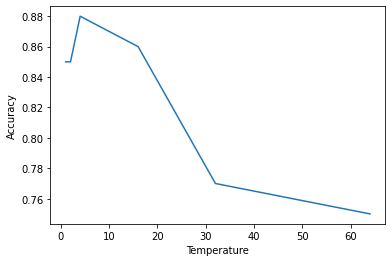

In [60]:
# your code start from here for step 6
Ts = [1, 2, 4, 16, 32, 64]
Accuracies = [0.85, 0.85, 0.88, 0.86, 0.77, 0.75]

plt.ylabel("Accuracy")
plt.xlabel("Temperature")
plt.plot(Ts, Accuracies)
plt.show()

# Train student from scratch

In [13]:
# your code start from here for step 7

train_and_evaluate(student_model_no_distillation, compute_plain_cross_entropy_loss, num_epochs=10, lr=1e-3)

student_model_no_distillation.trainable = True
train_and_evaluate(student_model_no_distillation, compute_plain_cross_entropy_loss, num_epochs=25, lr=1e-4)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [14]:
# your code start from here for step 8
print(f"Params for Teacher Model {teacher_model.count_params()}")
print(f"Params for Student Model {student_model.count_params()}")
print(f"Flops for Teacher Model {get_flops(teacher_model, batch_size=BATCH_SIZE)}")
print(f"Flops for Student Model {get_flops(student_model, batch_size=BATCH_SIZE)}")

Params for Teacher Model 23568898
Params for Student Model 2260546
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Flops for Teacher Model 223633626304
Flops for Student Model 19613863936


# Implementing the state-of-the-art KD algorithm

In [61]:
hint_model = tf.keras.models.Model(inputs=teacher_model.input, outputs=teacher_model.get_layer('resnet50v2').get_layer('conv3_block3_2_bn').output)

guide_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE, include_top=False, weights='imagenet')
guide_regressor = tf.keras.layers.Conv2D(128, 3, strides=1, padding="same")(guide_model.get_layer('block_5_project_BN').output)
guide_model = tf.keras.models.Model(inputs=guide_model.input, outputs=guide_regressor)

fitnet = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE, include_top=False, weights='imagenet')
fitnet.trainable = False

fitnet = tf.keras.Sequential([
    fitnet.input,
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    fitnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2),
])

In [62]:
def compute_fitnet_hidden_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_hidden = guide_model(images, training=True)
  teacher_hidden = hint_model(images, training=False)

  return tf.reduce_mean(tf.losses.mean_squared_error(student_hidden, teacher_hidden))

def compute_fitnet_loss(images, labels):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = fitnet(images, training=True)
  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  teacher_class_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_class_logits, 
                                              student_class_logits, 
                                              DISTILLATION_TEMPERATURE)
  
  # Compute cross-entropy loss with hard targets.
  cross_entropy_loss_value = tf.reduce_mean(
      tf.losses.categorical_crossentropy(labels, student_class_logits, 
                                         from_logits=True))
  
  return ALPHA * cross_entropy_loss_value + (1 - ALPHA) * distillation_loss_value

In [63]:
train_and_evaluate(guide_model, compute_fitnet_hidden_loss, num_epochs=10, if_eval=False, lr=1e-3)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: 

In [64]:
for i, layer in enumerate(guide_model.layers):
  t_layer = fitnet.get_layer('mobilenetv2_1.00_224').layers[i]
  if layer.name == t_layer.name:
    t_layer.set_weights(layer.get_weights())

In [ ]:
train_and_evaluate(fitnet, compute_fitnet_loss, num_epochs=10, lr=1e-3)

fitnet.trainable = True
train_and_evaluate(fitnet, compute_fitnet_loss, num_epochs=25, lr=1e-4)